In [1]:
import pandas as pd
#pandas
import numpy as np
#numpy
import matplotlib.pyplot as plt
#matplotlib
import seaborn as sns
#seaborn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#sklearn
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
#keras
import tensorflow as tf
#tensorflow
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
#nltk
import re
import os
#other useful stuff
from wordcloud import WordCloud, STOPWORDS
#wordclouds and cloud stopwords
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv', encoding = 'latin', header=None)

# **Exploratory data analysis**


In [3]:
data.head(10)

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


By looking at the top part of the dataset we can learn a lot from it. We can indicate which column refers to. Therefore, we can describe them briefly:


*   0 - target of sentiment
*   1 - id of user
*   2 - date of tweet
*   3 - unnecessary column, in each row contains 'NO_QUERY'
*   4 - nickname of author
*   5 - content of tweet   

### **Renaming column names**


Because of the numerical column names, it will be more convenient to work with a dataset with predefined column names.


In [4]:
data = data.rename(columns={0: 'target', 1: 'id', 2: 'date', 3: 'query', 4: 'username', 5: 'content'})

In [5]:
data.head(1)

,target,id,date,query,username,content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."


Now, columns of dataset are much more informative. 

### **Missing values**


Missing data is common occurance in datasets, therefore it is recommended to check if a data set contains missing values before starting any analysis. 

In [6]:
missing_data = data.isna().sum().sort_values(ascending=False)
percentage_missing = round((data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)*100,2)
missing_info = pd.concat([missing_data,percentage_missing],keys=['Missing values','Percentage'],axis=1)
missing_info.style.background_gradient()

,Missing values,Percentage
content,0,0.000000
username,0,0.000000
query,0,0.000000
date,0,0.000000
id,0,0.000000
target,0,0.000000


Fortunately, dataset is free of missing values. 

### **Targets**



Firstly let's see what the classes of the individual tweets are about.

In [7]:
pd.set_option('display.max_colwidth', -1)
data[data['target']==0]['content'].head()

0    @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
1    is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!    
2    @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds                          
3    my whole body feels itchy and like its on fire                                                                     
4    @nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.     
Name: content, dtype: object

By reading the content of the tweets, we can conclude that they have a rather negative message, so class 0 refers to negative sentiments tweets.

In [8]:
data[data['target']==4]['content'].head

<bound method NDFrame.head of 800000     I LOVE @Health4UandPets u guys r the best!!                                                                                              
800001     im meeting up with one of my besties tonight! Cant wait!!  - GIRL TALK!!                                                                 
800002     @DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart. 
800003     Being sick can be really cheap when it hurts too much to eat real food  Plus, your friends make you soup                                 
800004     @LovesBrooklyn2 he has that effect on everyone                                                                                           
                                ...                                                                                                                 
1599995    Just woke up. Having no school is the best feeling ever          

By reading the content of the tweets, we can conclude that they have a rather positive message, so class 4 refers to positive sentiments tweets.

In [9]:
data['target'] = data['target'].replace([0, 4],['Negative','Positive'])

Changing labels from 0 and 4 for more informative labels for further analysis. 

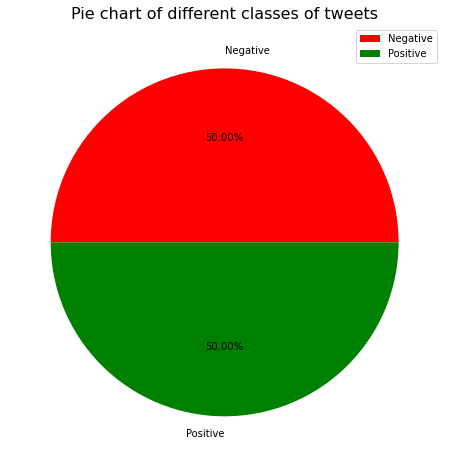

In [10]:
fig = plt.figure(figsize=(8,8))
targets = data.groupby('target').size()
targets.plot(kind='pie', subplots=True, figsize=(10, 8), autopct = "%.2f%%", colors=['red','green'])
plt.title("Pie chart of different classes of tweets",fontsize=16)
plt.ylabel("")
plt.legend()
plt.show()

In [11]:
data['target'].value_counts()

Negative    800000
Positive    800000
Name: target, dtype: int64

As we can see dataset is perfectly balanced with the same numbers of occurrences for both classes. It is also worth mentioning that the data is not skewed which will certainly make modeling easier. 

### **Length of tweet content**

Based on this analysis, we can find out the length of tweets for two particular classes of tweets.

In [12]:
data['length'] = data.content.str.split().apply(len)

Adding new column to dataset with length of particular tweets.

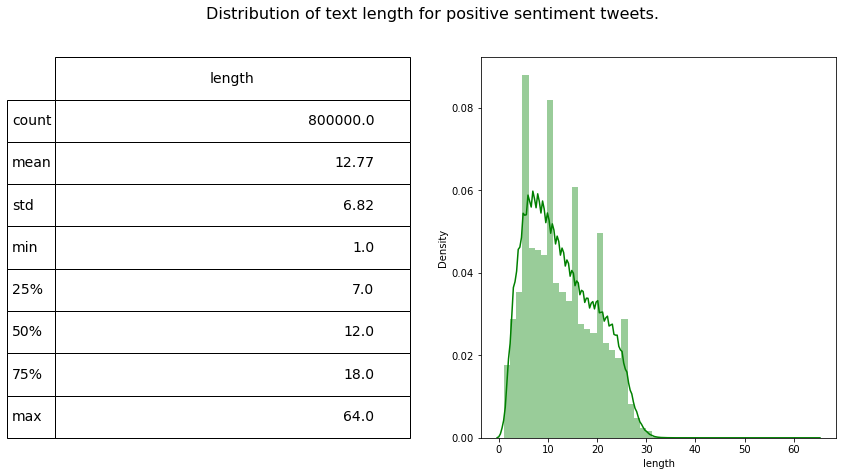

In [13]:
fig = plt.figure(figsize=(14,7))

ax1 = fig.add_subplot(122)
sns.distplot(data[data['target']=='Positive']['length'], ax=ax1,color='green')
describe = data.length[data.target=='Positive'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment tweets.', fontsize=16)

plt.show()

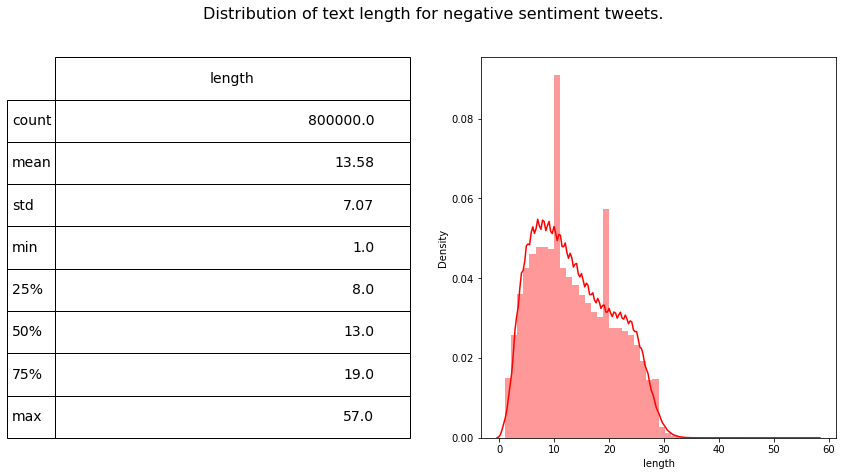

In [14]:
fig = plt.figure(figsize=(14,7))

ax1 = fig.add_subplot(122)
sns.distplot(data[data['target']=='Negative']['length'], ax=ax1,color='red')
describe = data.length[data.target=='Negative'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for negative sentiment tweets.', fontsize=16)

plt.show()

In such a large dataset, tweets belonging to two classes are almost the same lengths. However, the average tweet length for the negative class is about 0.8 words longer.

### **Most commonly tweeting users**


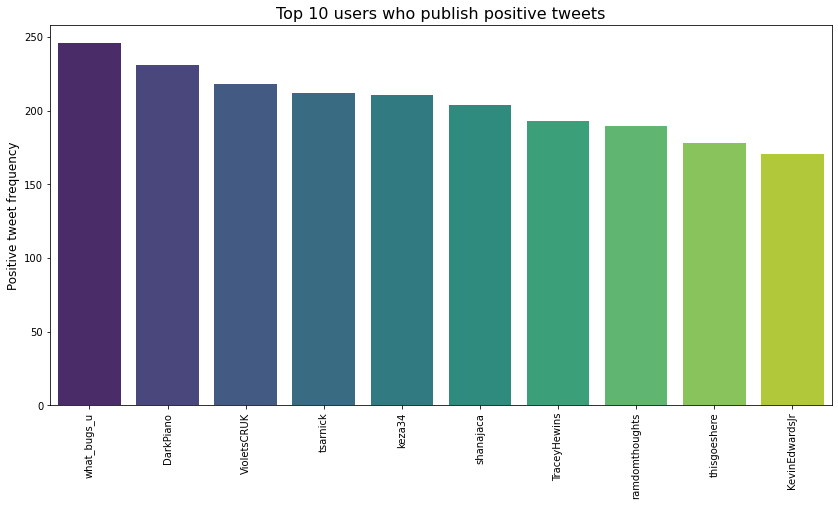

In [15]:
plt.figure(figsize=(14,7))
common_keyword=sns.barplot(x=data[data['target']=='Positive']['username'].value_counts()[:10].index, \
                           y=data[data['target']=='Positive']['username'].value_counts()[:10],palette='viridis')
common_keyword.set_xticklabels(common_keyword.get_xticklabels(),rotation=90)
common_keyword.set_ylabel('Positive tweet frequency',fontsize=12)
plt.title('Top 10 users who publish positive tweets',fontsize=16)
plt.show()

Seems like what_bugs_u is kind of a user who is in good mood really often.

In [16]:
data[data['username']=='what_bugs_u'].head()

,target,id,date,query,username,content,length
1141441,Positive,1977182027,Sat May 30 20:18:46 PDT 2009,NO_QUERY,what_bugs_u,"@JadeMcCray why limit your story to 140 chr. Tell all what is annoying you at www.iamsoannoyed.com ,it will help relieve your stress",22
1141626,Positive,1977198277,Sat May 30 20:21:22 PDT 2009,NO_QUERY,what_bugs_u,"@cadmiumcannibal why limit your story to 140 ch. Tell all what is annoying you at www.iamsoannoyed.com ,it will help relieve your stress",22
1141648,Positive,1977207353,Sat May 30 20:22:52 PDT 2009,NO_QUERY,what_bugs_u,"@RonanDosSantos why limit your story to 140 chr. Tell all what is annoying you at www.iamsoannoyed.com ,it will help relieve your stress",22
1141674,Positive,1977208245,Sat May 30 20:23:01 PDT 2009,NO_QUERY,what_bugs_u,"@ShayMac28 why limit your story to 140 chr. Tell all what is annoying you at www.iamsoannoyed.com ,it will help relieve your stress",22
1142667,Positive,1977331498,Sat May 30 20:43:12 PDT 2009,NO_QUERY,what_bugs_u,"@lynnsdecor why limit your story to 140 chr. Tell all what is annoying you at www.iamsoannoyed.com ,it will help relieve your stress",22


Based on the contet posted by the user, it can be concluded that this is not a regular user but it is just a bot.

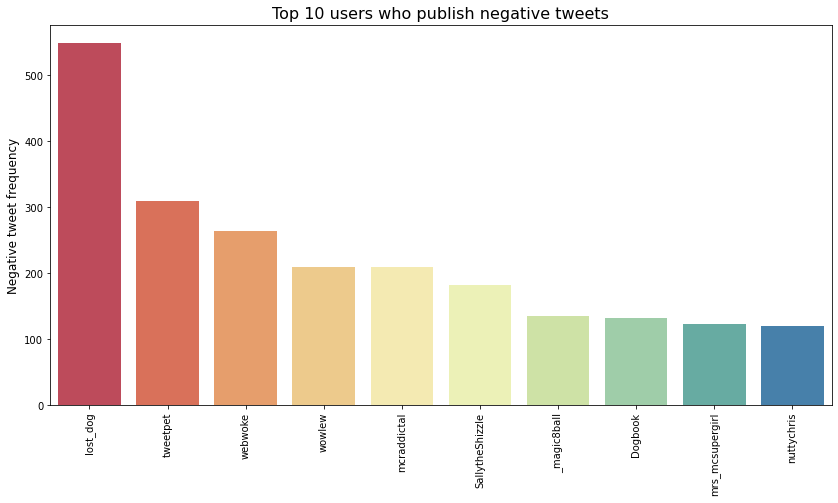

In [17]:
plt.figure(figsize=(14,7))
common_keyword=sns.barplot(x=data[data['target']=='Negative']['username'].value_counts()[:10].index, \
                           y=data[data['target']=='Negative']['username'].value_counts()[:10],palette='Spectral')
common_keyword.set_xticklabels(common_keyword.get_xticklabels(),rotation=90)
common_keyword.set_ylabel('Negative tweet frequency',fontsize=12)
plt.title('Top 10 users who publish negative tweets',fontsize=16)
plt.show()

In [18]:
data[data['username']=='lost_dog'].head()

,target,id,date,query,username,content,length
43935,Negative,1676704158,Fri May 01 22:54:02 PDT 2009,NO_QUERY,lost_dog,@NyleW I am lost. Please help me find a good home.,11
45574,Negative,1677189389,Sat May 02 00:51:35 PDT 2009,NO_QUERY,lost_dog,@SallyD I am lost. Please help me find a good home.,11
46919,Negative,1677519173,Sat May 02 02:30:50 PDT 2009,NO_QUERY,lost_dog,@zuppaholic I am lost. Please help me find a good home.,11
47949,Negative,1677752995,Sat May 02 03:47:51 PDT 2009,NO_QUERY,lost_dog,@LOSTPETUSA I am lost. Please help me find a good home.,11
50572,Negative,1678544903,Sat May 02 07:02:28 PDT 2009,NO_QUERY,lost_dog,@JeanLevertHood I am lost. Please help me find a good home.,11


It seems that lost dog bots are rather in a bad mood.

### **Wordclouds**

By creating word clouds for two classes, we can visualize what words were repeated most often for positive and negative classes. We don't want to show stopwords so i took base of stopwords from nltk library and i passed it to WordCloud function

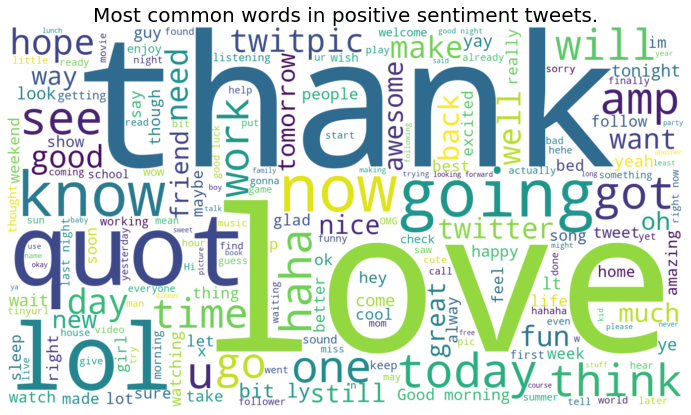

In [19]:
plt.figure(figsize=(14,7))
word_cloud = WordCloud(stopwords = STOPWORDS, max_words = 200, width=1366, height=768, background_color="white").generate(" ".join(data[data.target=='Positive'].content))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.title('Most common words in positive sentiment tweets.',fontsize=20)
plt.show()

Based on the word cloud, it can be deduced that the most repeated words in tweets with positive sentiment are words such as: love, quot, lol, haha, thank, today. 

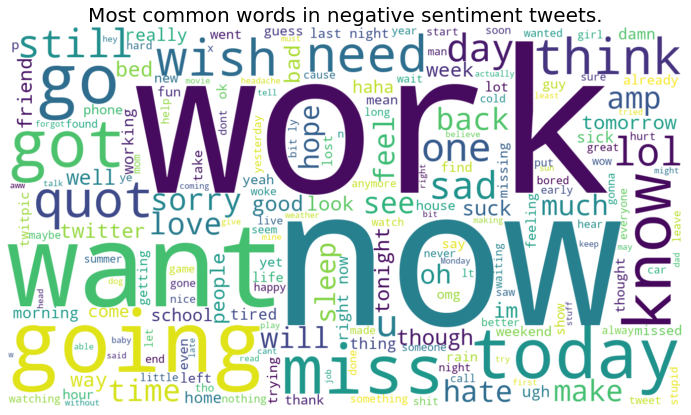

In [20]:
plt.figure(figsize=(14,7))
word_cloud = WordCloud(stopwords = STOPWORDS, max_words = 200, width=1366, height=768, background_color="white").generate(" ".join(data[data.target=='Negative'].content))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.title('Most common words in negative sentiment tweets.',fontsize=20)
plt.show()

Based on the word cloud, it can be deduced that the most repeated words in tweets with negative sentiment are words such as: quot, lol, today which are the same as for positive sentiment class. However, there are also word occurrences from which negative sentiment of a tweet can be inferred such as: miss, sorry, hate etc.

# **Data preparing**
### **Dropping unnecessary columns**


There are a lot of unnecessary columns in the following dataset. The task is to classify the semantics of a tweet, so all columns except the target and content columns are unnecessary. 

In [21]:
data.drop(['id','date','query','username','length'], axis=1, inplace=True)

In [22]:
data.head()

,target,content
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,Negative,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,Negative,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [23]:
data.target = data.target.replace({'Positive': 1, 'Negative': 0})

Replacing Positive and Negative labels with 1 and 0 respectively.

### **Content cleaning**

Stemming - it does refers to the process which goal is to reduce words into thier base form. In case of our problem for classification it is very important ooperation as we need to focus on the meaning of particular word. For instance words: *Running, Runned, Runner* all can reduce to the stem *Run*. Below we have used the base of english stopwords and stemming algorithm from nltk library. 

In [24]:
english_stopwords = stopwords.words('english')
#base of english stopwords
stemmer = SnowballStemmer('english')
#stemming algorithm
regex = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
#regex for mentions and links in tweets

In [25]:
def preprocess(content, stem=False):
  content = re.sub(regex, ' ', str(content).lower()).strip()
  tokens = []
  for token in content.split():
    if token not in english_stopwords:
      tokens.append(stemmer.stem(token))
  return " ".join(tokens)

In [26]:
data.content = data.content.apply(lambda x: preprocess(x))

In [27]:
data.head()

,target,content
0,0,awww bummer shoulda got david carr third day
1,0,upset updat facebook text might cri result school today also blah
2,0,dive mani time ball manag save 50 rest go bound
3,0,whole bodi feel itchi like fire
4,0,behav mad see


Head of data after stemming and removing https. 

### **Train test split**
Due to the rather large size of the dataset 160000 tweets will be enough for testing. 

In [28]:
train, test = train_test_split(data, test_size=0.1, random_state=44)

In [29]:
print('Train dataset shape: {}'.format(train.shape))
print('Test dataset shape: {}'.format(test.shape))

Train dataset shape: (1440000, 2)
Test dataset shape: (160000, 2)


### **Tokenization**

It is a particular kind of document segmentation. It does breaks up text into smaller chunks or segments called tokens. A tokenizer breaks unstructured data, natural language text, into chunks of information that can be counted as discrete elements. After this operation these counts of token occurences in particular document can be used as a vector representing given document.

In [30]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train.content)  
vocab_size = len(tokenizer.word_index) + 1 
max_length = 50

Based on the analysis of the tweet length it was concluded that the maximum length for tokenization equal to 50 will be sufficient

In [31]:
sequences_train = tokenizer.texts_to_sequences(train.content) 
sequences_test = tokenizer.texts_to_sequences(test.content) 

X_train = pad_sequences(sequences_train, maxlen=max_length, padding='post')
X_test = pad_sequences(sequences_test, maxlen=max_length, padding='post')

y_train = train.target.values
y_test = test.target.values

### **Word embeddings using GloVe**

Word embeddings provide a dense representation of words and their relative meanings. Embedding Matrix is a maxtrix of all words and their corresponding embeddings. Embedding matrix is used in embedding layer in model to embedded a token into it's vector representation, that contains information regarding that token or word.

Embedding vocabulary is taken from the tokenizer and the corresponding vectors from embedding model, which in this case is GloVe model. GloVe stand for Global Vectors for Word Representation 
and it is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

Below was used pretrained GloVe embeddings from world known Stanford vector files. The smallest available file contains embeddings created for tiny 6 billions of tokens.  

In [32]:
embeddings_dictionary = dict()
embedding_dim = 100
glove_file = open('/kaggle/input/glove6b100dtxt/glove.6B.100d.txt')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
    
glove_file.close()

embeddings_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embeddings_matrix[index] = embedding_vector

# **Model test harness** 

The proposed model architecture will be tested on the following parameters:

*   **loss** = "binnary_crossentropy" (due to binary classification problem)
*   **optimizer** = Adam(learning_rate=0.001) (may be changed after seeing the learning graph)
*   **metrics** = "accuracy" (due to binary classification problem)
*   **number of epochs** = 10 (due to the large training data set)
*   **batch size** = 1000 (in order to accelerate learning time)

In [33]:
embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False)

In [34]:
num_epochs = 10
batch_size = 1000

# **Model - Embedding + Stacked LSTM**


Model consisted of layers build with lstm cells. With such a large amount of data, the model is computationally complex making the training process take a while. Furthermore, model regularization layers will reduce the possible overfitting which was present in the simpler models tested.

In [35]:
model = Sequential([
        embedding_layer,
        tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Bidirectional(LSTM(128)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           26901500  
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 256)           234496    
_________________________________________________________________
dropout (Dropout)            (None, 50, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

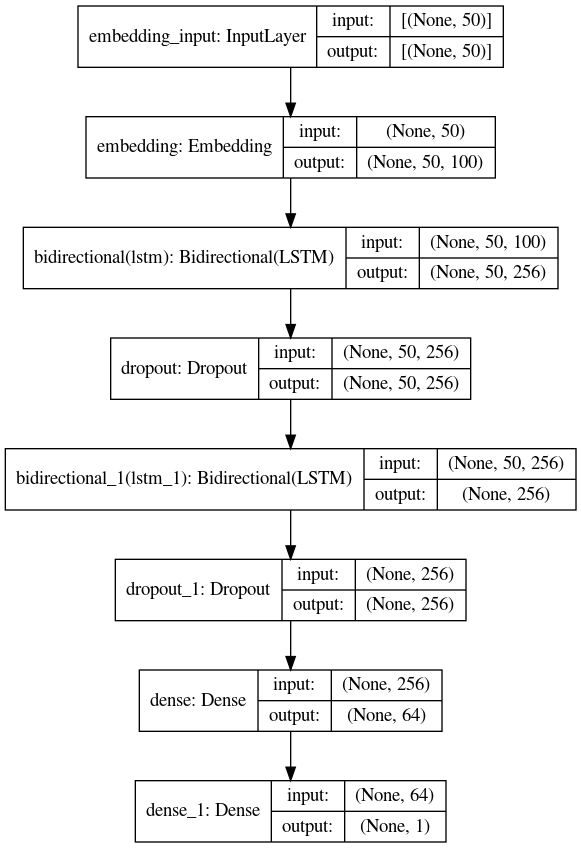

In [37]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [38]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size = batch_size, epochs=num_epochs, validation_data=(X_test, y_test), verbose=2)

Epoch 1/10
1440/1440 - 104s - loss: 0.5315 - accuracy: 0.7287 - val_loss: 0.5078 - val_accuracy: 0.7466
Epoch 2/10
1440/1440 - 94s - loss: 0.5007 - accuracy: 0.7520 - val_loss: 0.4938 - val_accuracy: 0.7562
Epoch 3/10
1440/1440 - 94s - loss: 0.4895 - accuracy: 0.7596 - val_loss: 0.4883 - val_accuracy: 0.7600
Epoch 4/10
1440/1440 - 94s - loss: 0.4810 - accuracy: 0.7649 - val_loss: 0.4843 - val_accuracy: 0.7624
Epoch 5/10
1440/1440 - 94s - loss: 0.4743 - accuracy: 0.7695 - val_loss: 0.4833 - val_accuracy: 0.7632
Epoch 6/10
1440/1440 - 94s - loss: 0.4681 - accuracy: 0.7733 - val_loss: 0.4787 - val_accuracy: 0.7668
Epoch 7/10
1440/1440 - 94s - loss: 0.4622 - accuracy: 0.7768 - val_loss: 0.4798 - val_accuracy: 0.7667
Epoch 8/10
1440/1440 - 94s - loss: 0.4570 - accuracy: 0.7800 - val_loss: 0.4792 - val_accuracy: 0.7671
Epoch 9/10
1440/1440 - 94s - loss: 0.4516 - accuracy: 0.7831 - val_loss: 0.4804 - val_accuracy: 0.7663
Epoch 10/10
1440/1440 - 94s - loss: 0.4462 - accuracy: 0.7866 - val_loss

In [39]:
y_pred = model.predict(X_test)
y_pred = np.where(y_pred>0.5, 1, 0)

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.75      0.76     79800
           1       0.76      0.79      0.77     80200

    accuracy                           0.77    160000
   macro avg       0.77      0.77      0.77    160000
weighted avg       0.77      0.77      0.77    160000



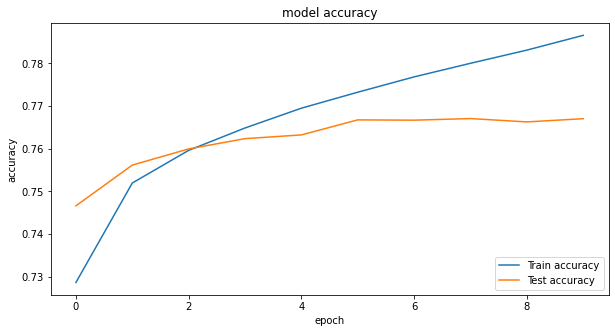

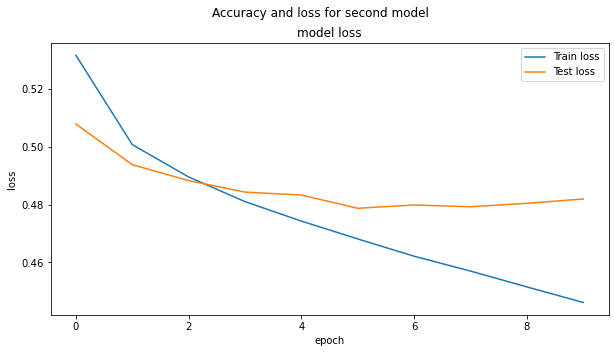

In [41]:
#History for accuracy
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train accuracy', 'Test accuracy'], loc='lower right')
plt.show()
# History for loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train loss', 'Test loss'], loc='upper right')
plt.suptitle('Accuracy and loss for second model')
plt.show()

### Conclusions

*   Presetned model performed quite good but there is also visible overfitting, learning rate increase or other hyperparameter tuning should help
*   Larger dropout layers also could help with overfitting.
*   Another improvement might be to use a more complex embedding layer. For example: GloVe 300d.
*   High accuracy was not achieved for the training data which may indicate an unrepresentative training dataset. 